# Block Zone Simulator

This notebook / repo will be used to play around with block zone configurations and run simulations to determine the theoretical and practical capacity of an attraction.

In [1]:
# define blocks

blocks = {
    'station': {
        'next_block': 'lift 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': None,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': True,
        'hold_time': 38
    },
    'lift 1': {
        'next_block': 'gravity 1',
        'seconds_to_reach_block': 18,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'gravity 1': {
        'next_block': 'lift 2',
        'seconds_to_reach_block': 30,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'lift 2': {
        'next_block': 'gravity 2',
        'seconds_to_reach_block': 20,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'gravity 2': {
        'next_block': 'final block 1',
        'seconds_to_reach_block': 22,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'final block 1': {
        'next_block': 'station',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    }
}

# define optional params
optional_params = {
    'sluggishness': True,
    'sluggishness_mu': 1.5,
    'sluggishness_sigma': 0.6,
    'random_seed': 10
}

In [6]:
from circuit import Circuit

circuit = Circuit(blocks, num_trains=4, optional_params=optional_params)

In [7]:
# run the sim
for _ in range(36000):
    circuit.step()

In [8]:
#trains
circuit.trains

{'train 0': <train.Train at 0x2c3a4cea4e0>,
 'train 1': <train.Train at 0x2c3a4cea860>,
 'train 2': <train.Train at 0x2c3a4cea978>,
 'train 3': <train.Train at 0x2c3a4cea9e8>}

In [9]:
# question - what percent of the sim run time did each train sit idle?
for train_name in circuit.trains:
    print(round(100*circuit.trains[train_name].total_seconds_held / circuit.time, 2))
    
# if we set run time to 1 million seconds, they all converge to the same % idle.

26.16
26.34
26.16
26.24


In [10]:
circuit.blocks

{'station': <block.Block at 0x2c3a4cea668>,
 'lift 1': <block.Block at 0x2c3a4cea6d8>,
 'gravity 1': <block.Block at 0x2c3a4cea5c0>,
 'lift 2': <block.Block at 0x2c3a4cea7f0>,
 'gravity 2': <block.Block at 0x2c3a4cea588>,
 'final block 1': <block.Block at 0x2c3a4cea4a8>}

In [11]:
num_riders_per_train = 24
avg_cycles_completed = sum([circuit.trains[train].circuits_completed for train in circuit.trains]) / len(circuit.trains)
avg_cycles_per_hour = avg_cycles_completed * 3600 / circuit.time
total_cycles_per_hour = avg_cycles_per_hour * len(circuit.trains)
total_hourly_capacity = num_riders_per_train * total_cycles_per_hour
total_hourly_capacity # 463 (1) 928.8 (2) 1394 (3) 1378 (4)

1274.4

In [12]:
import random
import numpy as np

rng = np.random.default_rng(10)


mean sluggishness:	 5.359
0th percentile: 	0.363
25th percentile: 	2.996
50th percentile: 	4.482
75th percentile: 	6.71
100th percentile: 	56.16


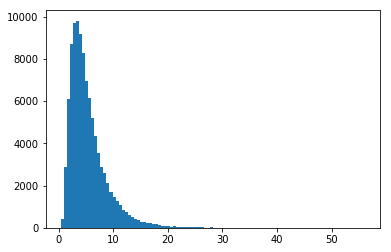

In [45]:
from matplotlib import pyplot as plt

simulated_sluggishness = rng.lognormal(mean=1.5, sigma=0.6, size=100000)
print(f"mean sluggishness:\t {round(simulated_sluggishness.mean(),3)}")
for p in [0, 25, 50, 75, 100]:
    print(f"{p}th percentile: \t{round(np.percentile(simulated_sluggishness,p),3)}")

plt.hist(simulated_sluggishness, bins=100)
plt.show()

# lognormal distribution with mean=1.5 and sigma=0.6 seems to give realistic load time slowdowns.
# mean is 5.34, or approx. 5 seconds above theoretical dispatch


## Example Study

### Comparing Theoretical vs. Actual Capacity

Using the toy example in this notebook, we can compare theoretical vs actual capacity with both simulated load/unload sluggishness and perfect dispatches.

In [21]:
from circuit import Circuit
import numpy as np
import pandas as pd

blocks = {
    'station': {
        'next_block': 'lift 1',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': None,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': True,
        'hold_time': 38
    },
    'lift 1': {
        'next_block': 'gravity 1',
        'seconds_to_reach_block': 18,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'gravity 1': {
        'next_block': 'lift 2',
        'seconds_to_reach_block': 30,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'lift 2': {
        'next_block': 'gravity 2',
        'seconds_to_reach_block': 20,
        'seconds_to_clear_from_held': 8,
        'seconds_to_clear_block_in_motion': 7,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'gravity 2': {
        'next_block': 'final block 1',
        'seconds_to_reach_block': 22,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    },
    'final block 1': {
        'next_block': 'station',
        'seconds_to_reach_block': 8,
        'seconds_to_clear_from_held': 6,
        'seconds_to_clear_block_in_motion': 3,
        'is_occupied': False,
        'can_operate_from_stop': True,
        'mandatory_hold': False,
        'hold_time': None
    }
}

optional_params = {
    'sluggishness': True,
    'sluggishness_mu': 1.5,
    'sluggishness_sigma': 0.6,
    'random_seed': 10
}

def calculate_hourly_capacity(vehicle_capacity, circuit):
    avg_cycles_completed = sum([circuit.trains[train].circuits_completed for train in circuit.trains]) / len(circuit.trains)
    avg_cycles_per_hour = avg_cycles_completed * 3600 / circuit.time
    total_cycles_per_hour = avg_cycles_per_hour * len(circuit.trains)
    total_hourly_capacity = vehicle_capacity * total_cycles_per_hour
    return total_hourly_capacity

theoretical_capacities = []
theoretical_idle_percents = []
actual_capacities = []
actual_idle_percents = []

sim_run_time = 36000  # 10 hours (60s * 60min * 10hr)

for n in [1, 2, 3, 4, 5]:
    # run without sluggishness
    optional_params['sluggishness'] = False
    circuit = Circuit(blocks, num_trains=n, optional_params=optional_params)
    for _ in range(sim_run_time):
        circuit.step()
    # analyze results
    theoretical_capacities.append(calculate_hourly_capacity(vehicle_capacity=24, circuit=circuit))
    train_idles = []
    for train_name in circuit.trains:
        train_idles.append(100*circuit.trains[train_name].total_seconds_held / circuit.time)
    theoretical_idle_percents.append(round(np.mean(train_idles),2))
    # run again with sluggishness
    optional_params['sluggishness'] = True
    circuit = Circuit(blocks, num_trains=n, optional_params=optional_params)
    for _ in range(sim_run_time):
        circuit.step()
    actual_capacities.append(calculate_hourly_capacity(vehicle_capacity=24, circuit=circuit))
    train_idles = []
    for train_name in circuit.trains:
        train_idles.append(100*circuit.trains[train_name].total_seconds_held / circuit.time)
    actual_idle_percents.append(round(np.mean(train_idles),2))

df = pd.DataFrame({
    'num_trains': list(range(1,6)),
    'theoretical_capacity': theoretical_capacities,
    'actual_capacity': actual_capacities,
    'theoretical_idle_percents': theoretical_idle_percents,
    'actual_idle_percents': actual_idle_percents
})

df

,num_trains,theoretical_capacity,actual_capacity,theoretical_idle_percents,actual_idle_percents
0,1,463.2,453.6,0.00,0.00
1,2,928.8,904.8,0.00,0.04
2,3,1394.4,1276.8,0.01,3.95
3,4,1377.6,1274.4,22.69,26.23
4,5,1375.2,1274.4,35.67,38.94


From the above results, we can see that the highest theoretical capacity for this circuit with 6 complete block zones is 1,394 riders per hour, when operating 3 trains.  Operating four or more trains slightly decreases this theoretical capacity.  Adding dispatch delay times to the simulation shows a decrease in achieved throughput of approximately 117 riders per hour for a total capacity of 1,277 riders per hour.

Operating 3 trains over 6 blocks should result in smooth operations with no unnecessary idle time.  Adding simulated dispatch delay introduces some unnecessary delay to the system, but a further investigation into which block zones experience these extra holds is warranted.